# Ocular Diseases Classification using Deep Learning Techniques
## Project Overview
This project aims to develop a deep learning model for the classification of retinal images to identify various eye diseases. The focus is on four specific conditions: **Normal, Diabetic Retinopathy, Cataract, and Glaucoma**. 

By analyzing these images, we can assist in early diagnosis and treatment, ultimately improving patient outcomes.

## Dataset Description
The dataset used for this project comprises retinal images categorized into four classes:
* Normal: Healthy retinal images with no abnormalities
* Diabetic Retinopathy: Images showing signs of diabetic eye disease.
* Cataract: Images indicating the presence of cataracts in the lens of the eye.
* Glaucoma: Images that reveal signs of glaucoma, which affects the optic nerve.

Each class contains approximately 1,000 images, providing a balanced dataset for training and evaluation. The images have been sourced from various reputable databases, including:

* IDRiD: Indian Diabetic Retinopathy Image Dataset
* Ocular Recognition: A database focused on ocular disease recognition
* HRF: High-Resolution Fundus dataset

Source of Dataset:
*https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification/data*

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

from powermanagement import long_running 

%autosave 30

Autosaving every 30 seconds


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import pandas as pd
telltimefnx = lambda :print('','='*100,f"\nTime Now: {pd.Timestamp.now().strftime('%Y.%m.%d %I:%M %p')}",'\n','='*100)
telltimefnx()

Time Now: 2024.12.12 10:25 AM 


## Dataset Exploration
* Identification of number of samples for each category
* Creation of a unified dataframe, containing paths and respective category

In [4]:
dataPath = r"C:\Users\asuto\Desktop\Work\Eye Diseases\dataset"
os.listdir(dataPath)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [5]:
%%time
total = 0
for disease in os.listdir(dataPath):
    diseasePath = os.path.join(dataPath,disease)
    print(f"Number of samples for {disease} case: {len(os.listdir(diseasePath))}")
    total += len(os.listdir(diseasePath))
print(f"Total samples: {total}")

Number of samples for cataract case: 1038
Number of samples for diabetic_retinopathy case: 1098
Number of samples for glaucoma case: 1007
Number of samples for normal case: 1074
Total samples: 4217
CPU times: total: 15.6 ms
Wall time: 46.1 ms


In [6]:
%%time
diseaseMap = {"filepath":[],"label":[]}

for disease in tqdm(os.listdir(dataPath)):
    diseasePath = os.path.join(dataPath,disease)

    for path in os.listdir(diseasePath):
        diseaseMap['filepath'].append(os.path.join(dataPath,disease,path))
        diseaseMap['label'].append(disease)

opticDf = pd.DataFrame(diseaseMap).sample(frac=1)
opticDf.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 192.31it/s]

CPU times: total: 46.9 ms
Wall time: 42.2 ms


,filepath,label
491,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
1533,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy
2275,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,glaucoma
577,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
2431,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,glaucoma


In [7]:
# opticDf.to_csv(r"C:\Users\asuto\Desktop\Work\Eye Diseases\opticDiseasesDataframe.csv",index=False)

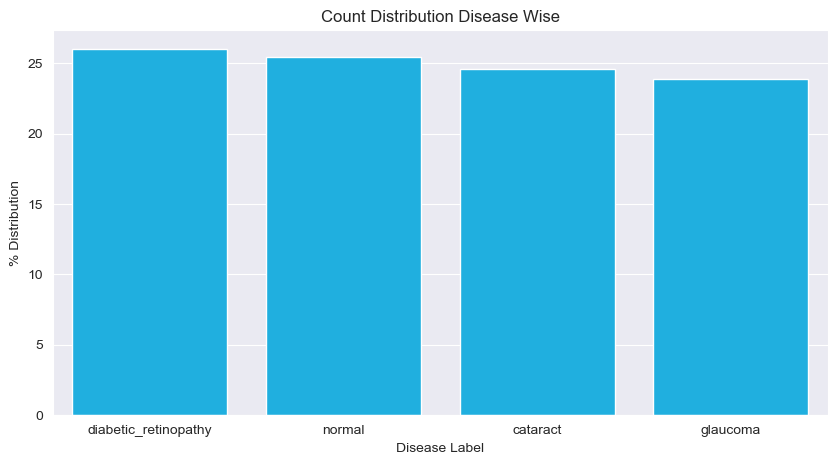

In [8]:
plt.figure(figsize=(10,5),dpi=100)
sns.barplot(opticDf.label.value_counts(normalize=True)*100,color='deepskyblue')
plt.xlabel("Disease Label")
plt.ylabel("% Distribution")
plt.title('Count Distribution Disease Wise')
plt.show()

## Image Exploration & Brief on Ocular Diseases
### Brief on Ocular Diseases
* **Normal:** Normal retinal images show a healthy eye without any issues. This is the baseline for comparison when looking for signs of disease.
* **Diabetic Retinopathy:** Diabetic Retinopathy is a condition that can happen in people with diabetes. It affects the blood vessels in the retina and can lead to vision problems. Early signs include tiny bulges and spots on the retina. If not caught early, it can worsen and cause serious vision loss.
* **Cataract:** Cataracts make the lens of the eye cloudy, which can blur vision. They are often related to aging but can also be caused by other factors like diabetes or eye injuries. People with cataracts may notice difficulty seeing at night or glare from bright lights. Surgery can help restore clear vision.

* **Glaucoma:** Glaucoma involves damage to the optic nerve, often due to high pressure in the eye. It can lead to vision loss if not treated. Many people don’t notice symptoms in the early stages, so regular eye check-ups are important for detection. There are different types, with open-angle glaucoma being the most common.

**Importance of Early Detection:**

Identification these diseases early is crucial to prevent vision loss. Regular eye exams can help identify problems before they become serious, making it important to analyze eye images for signs of these conditions.



In [9]:
def displayImg(sample,scaleImage = True):
    imgName,label = sample['filepath'].item().split('\\')[-1],sample['label'].item()
    path = sample['filepath'].item()
    img = mpimg.imread(path)

    if scaleImage:
        img = img / 255
        
    plt.figure(figsize= (6,6),dpi=80)
    imgplot = plt.imshow(img)
    plt.title(f"{imgName}:{label}",color= 'blue', fontsize= 12)
    plt.show()
    return img

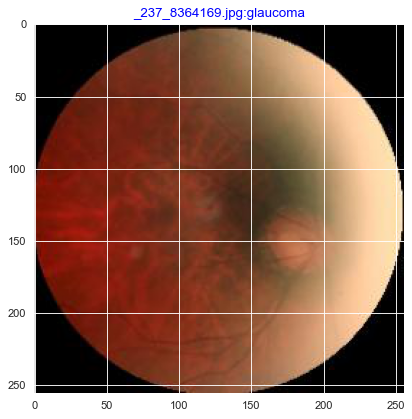

In [10]:
sample = opticDf.sample(1)
img = displayImg(sample)

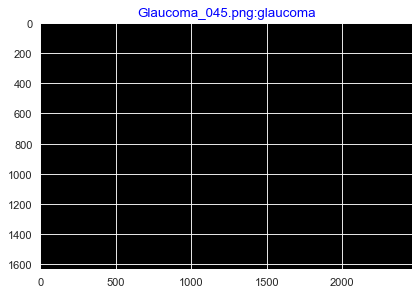

In [11]:
sample = opticDf.sample(1)
img = displayImg(sample)

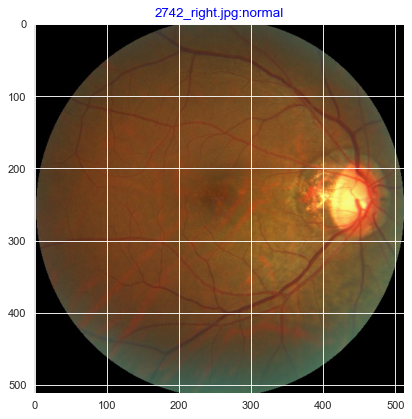

In [12]:
sample = opticDf.sample(1)
img = displayImg(sample)

In [13]:
print(img.shape)

(512, 512, 3)


---
## Data Splitting, Image Preprocessing and Generator

### Train Test Split
* Creation of Training, Validation and Testing Samples
* Splitting the dataframe into 70% Training, 15% Validation and 15% Testing datapoints.

In [14]:
opticDf.head()

,filepath,label
491,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
1533,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy
2275,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,glaucoma
577,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
2431,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,glaucoma


In [15]:
#Creating Training Samples and a Dummy DF
trainSamples,dumSamples = train_test_split(opticDf,test_size=0.3,stratify=opticDf['label'])
#Creating Testing and Validation Samples from the Dummy DF
testSamples,validSamples = train_test_split(dumSamples,test_size=0.5,stratify=dumSamples['label'])

In [16]:
print("Training Data Size:", trainSamples.shape[0])
print("Validation Data Size:", validSamples.shape[0])
print("Testing Data Size:", testSamples.shape[0])

Training Data Size: 2951
Validation Data Size: 633
Testing Data Size: 633


### Image Generator
Preprocessing Steps:
* Image Resizing: Original (512,512) --> Standard (256,256)
* Image Standardization: IMG x (1/255)

**Image Resizing:**
Image resizing ensures all images have the same dimensions, which is essential for model compatibility and processing.

**Image Standardization:**
Image standardization ensures consistent pixel value distributions across all images, making it easier for the model to learn and perform well. By reducing the impact of lighting and contrast differences, it allows the model to focus on the actual patterns in the data.

In [17]:
img.shape

(512, 512, 3)

In [18]:
#Target Image Size. Original Image Size is (512,512)
imageSize = (256, 256)
color = 'rgb'
colorChannel = 3
imageShape = (imageSize[0],imageSize[1],colorChannel)
batch_size = 6

imgGen = ImageDataGenerator(rescale = 1/255)

In [19]:
trainGen = imgGen.flow_from_dataframe(trainSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)
valGen = imgGen.flow_from_dataframe(validSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)
testGen = imgGen.flow_from_dataframe(testSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.


Image Shape after shape preprocessing: (256, 256, 3)



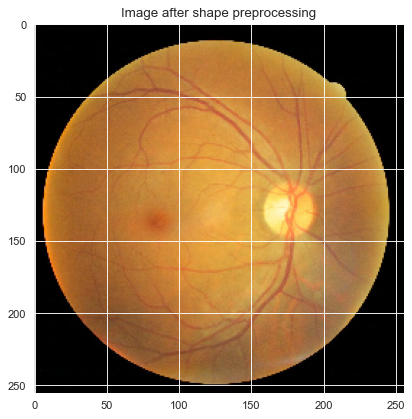

In [20]:
sampleImg = next(iter(trainGen))[0][0]
print(f"Image Shape after shape preprocessing: {sampleImg.shape}\n")

plt.figure(figsize= (6,6),dpi=80)
imgplot = plt.imshow(sampleImg)
plt.title("Image after shape preprocessing")
plt.show()

In [21]:
np.max(sampleImg),np.min(sampleImg)

(1.0, 0.0)

---
## Model Development
Using the power of Convolution and Convolutional Neural Networks

**Convolutional Neural Networks:**

Convolutional Neural Networks (CNNs) are a type of deep learning architecture designed for processing grid-like data, such as images. They utilize convolutional layers to automatically detect features like edges and textures by applying filters to the input. Pooling layers reduce the spatial dimensions, helping to maintain important information while lowering computational costs. CNNs typically include fully connected layers at the end for classification tasks. They are highly effective in tasks such as image recognition and object detection due to their ability to learn hierarchical features.

**Sample CNN Architecture**

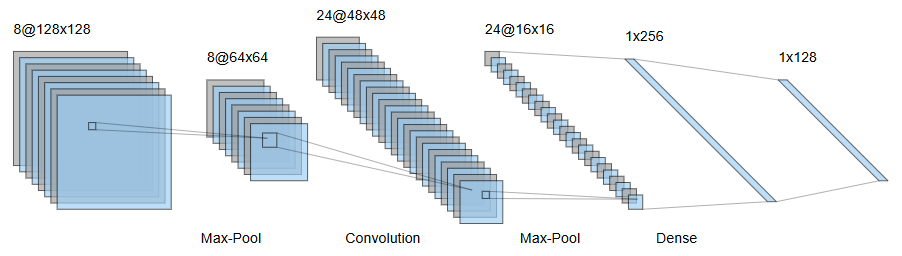

In [22]:
@long_running
def modelTrainingFnx(model,epochs,trainGen=trainGen,valGen=valGen,verbose=1):
    '''Verbose:0 = silent, 1 = progress bar, 2 = one line per epoch.'''
    tf.keras.backend.clear_session()
    # history = model.fit(x=trainGen,validation_data=valGen,epochs=epochs,verbose=0, callbacks=[TQDMNotebookCallback()])
    history = model.fit(x=trainGen,validation_data=valGen,epochs=epochs,verbose=verbose)
    return model,history 

In [23]:
def plotModelTraining(history):
    historyDf = pd.DataFrame(history.history).reset_index()
    historyDf['index'] += 1
    f, ax= plt.subplots(1, 2, sharey=False,figsize=(15,5),dpi=100)

    sns.lineplot(data=historyDf,x='index',y='loss',color='limegreen',ax=ax[0])
    sns.lineplot(data=historyDf,x='index',y='val_loss',color='red',ax=ax[0])
    sns.lineplot(data=historyDf,x='index',y='accuracy',color='limegreen',ax=ax[1])
    sns.lineplot(data=historyDf,x='index',y='val_accuracy',color='red',ax=ax[1])
    
    ax[0].set_title(f'Loss v/s Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    
    ax[1].set_title(f'Accuracy v/s Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    plt.show()

### Model Record

In [24]:
dataPath = r"C:\Users\asuto\Desktop\Work\Eye Diseases\\"

if 'modelRecord.csv' in os.listdir(dataPath):
  modelRecord = pd.read_csv(dataPath+'/'+'modelRecord.csv')
else:
  modelRecord = pd.DataFrame({'ModelName':[],'testAccuracy':[],'testF1':[],'testPrecision':[],'testRecall':[]})
  modelRecord.to_csv(dataPath+'/'+'modelRecord.csv',index=False)

In [43]:
# Helper Functions
def resultRecordFnx(report,modelname,modelRecord=modelRecord):
  '''
  Feed classification report, modelname
  '''
  acc,pre,rec,f1 = report['accuracy'],report['macro avg']['precision'],report['macro avg']['recall'],report['macro avg']['f1-score']
  if modelname in modelRecord['ModelName'].values:
    modelRecord.loc[modelRecord['ModelName'] == modelname,:] = [modelname,acc,f1,pre,rec]
  else:
    modelRecord.loc[len(modelRecord)] = {'ModelName':modelname,'testAccuracy':acc,'testF1':f1,'testPrecision':pre,'testRecall':rec}
  modelRecord.to_csv(dataPath+'/'+'modelRecord.csv',index=False)

def resultAnalysisFnx(ytrue,ypred,target_names=None):
    print(classification_report(ytrue,ypred,target_names = target_names))

    conf_matrix = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names)
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True)

---
### Custom Model 1

In [27]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,strides=(1,1),activation='relu',padding='same',input_shape=imageShape),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

#### Model Training

In [29]:
%%time
telltimefnx()
model,history = modelTrainingFnx(model,epochs=30)
telltimefnx()

Time Now: 2024.12.12 10:26 AM 
Epoch 1/30
492/492 [==============================] - 36s 59ms/step - loss: 0.9218 - accuracy: 0.5869 - val_loss: 0.6258 - val_accuracy: 0.7093
Epoch 2/30
492/492 [==============================] - 28s 57ms/step - loss: 0.6830 - accuracy: 0.7106 - val_loss: 0.6072 - val_accuracy: 0.7330
Epoch 3/30
492/492 [==============================] - 29s 59ms/step - loss: 0.5380 - accuracy: 0.7784 - val_loss: 0.4818 - val_accuracy: 0.8025
Epoch 4/30
492/492 [==============================] - 32s 64ms/step - loss: 0.4692 - accuracy: 0.8096 - val_loss: 0.5023 - val_accuracy: 0.8009
Epoch 5/30
492/492 [==============================] - 31s 63ms/step - loss: 0.4330 - accuracy: 0.8275 - val_loss: 0.5367 - val_accuracy: 0.7425
Epoch 6/30
492/492 [==============================] - 44s 89ms/step - loss: 0.4129 - accuracy: 0.8295 - val_loss: 0.5001 - val_accuracy: 0.8073
Epoch 7/30
492/492 [==============================] - 40s 82ms/step - loss: 0.3810 - accuracy: 0.8465 - v

#### Loss Progression

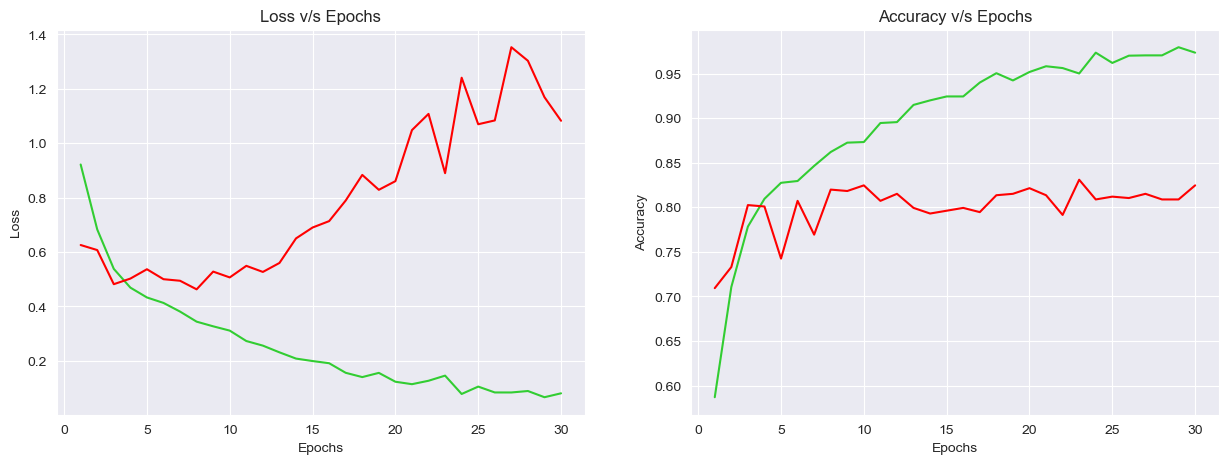

In [30]:
plotModelTraining(history)

#### Model Evaluation

In [31]:
test_score = model.evaluate(testGen, steps= None, verbose= 1)

106/106 [==============================] - 6s 56ms/step - loss: 0.8002 - accuracy: 0.8547


In [32]:
print("Test Loss: ", test_score[0])
print(f"Test Accuracy: {(test_score[1])*100} %")

Test Loss:  0.8001687526702881
Test Accuracy: 85.46603322029114 %


In [33]:
%%time
classes = list(testGen.class_indices.keys())
preds = model.predict(testGen)
yPred = np.argmax(preds, axis=1)

106/106 [==============================] - 5s 36ms/step
CPU times: total: 5.33 s
Wall time: 5.09 s


                      precision    recall  f1-score   support

            cataract       0.29      0.28      0.28       156
diabetic_retinopathy       0.26      0.27      0.27       165
            glaucoma       0.20      0.21      0.20       151
              normal       0.26      0.25      0.26       161

            accuracy                           0.25       633
           macro avg       0.25      0.25      0.25       633
        weighted avg       0.25      0.25      0.25       633



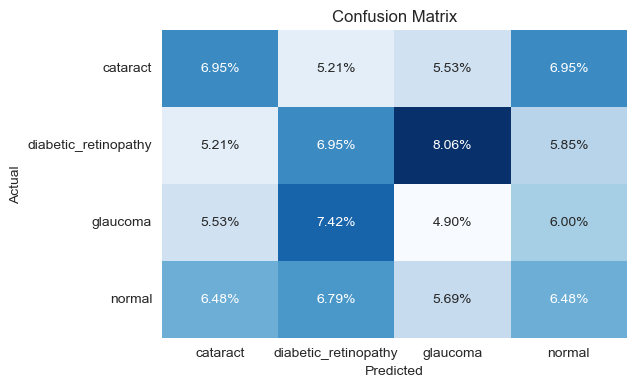

In [46]:
report = resultAnalysisFnx(testGen.classes,yPred,classes)

In [51]:
resultRecordFnx(report, 'custom1TensorFlow')
modelRecord

,ModelName,testAccuracy,testF1,testPrecision,testRecall
0,custom1TensorFlow,0.252765,0.252312,0.25248,0.252169


### Custom Model 2

In [52]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=4,strides=(1,1),activation='relu',padding='same',input_shape=imageShape),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(filters=32,kernel_size=5,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

#### Model Training

In [54]:
%%time
telltimefnx()
model,history = modelTrainingFnx(model,epochs=30)
telltimefnx()

Time Now: 2024.12.12 11:11 AM 
Epoch 1/30
492/492 [==============================] - 27s 52ms/step - loss: 1.2254 - accuracy: 0.4293 - val_loss: 0.9164 - val_accuracy: 0.6145
Epoch 2/30
492/492 [==============================] - 23s 47ms/step - loss: 0.7754 - accuracy: 0.6422 - val_loss: 0.6673 - val_accuracy: 0.6761
Epoch 3/30
492/492 [==============================] - 25s 50ms/step - loss: 0.6645 - accuracy: 0.6916 - val_loss: 0.6338 - val_accuracy: 0.6983
Epoch 4/30
492/492 [==============================] - 26s 52ms/step - loss: 0.6486 - accuracy: 0.6987 - val_loss: 0.6106 - val_accuracy: 0.7109
Epoch 5/30
492/492 [==============================] - 26s 53ms/step - loss: 0.6326 - accuracy: 0.7021 - val_loss: 0.6167 - val_accuracy: 0.7014
Epoch 6/30
492/492 [==============================] - 27s 55ms/step - loss: 0.6202 - accuracy: 0.7099 - val_loss: 0.6291 - val_accuracy: 0.7077
Epoch 7/30
492/492 [==============================] - 27s 55ms/step - loss: 0.6130 - accuracy: 0.7170 - v

#### Loss Progression

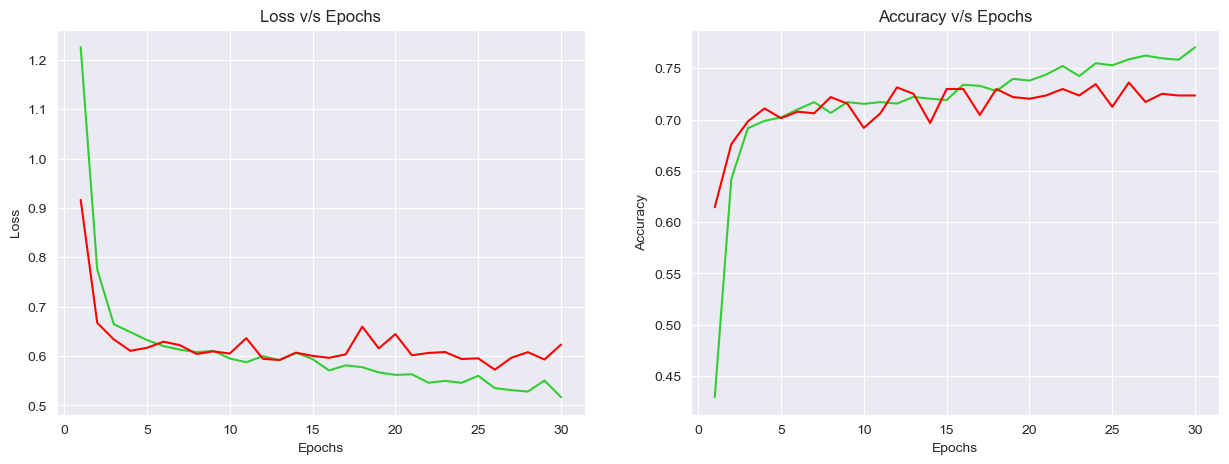

In [58]:
plotModelTraining(history)

#### Model Evaluation

In [55]:
test_score = model.evaluate(testGen, steps= None, verbose= 1)
print("Test Loss: ", test_score[0])
print(f"Test Accuracy: {(test_score[1])*100} %", )

106/106 [==============================] - 4s 40ms/step - loss: 0.6064 - accuracy: 0.7472
Test Loss:  0.6063861846923828
Test Accuracy: 74.7235357761383 %


106/106 [==============================] - 4s 36ms/step
                      precision    recall  f1-score   support

            cataract       0.27      0.27      0.27       156
diabetic_retinopathy       0.28      0.28      0.28       165
            glaucoma       0.22      0.14      0.17       151
              normal       0.26      0.34      0.29       161

            accuracy                           0.26       633
           macro avg       0.26      0.26      0.25       633
        weighted avg       0.26      0.26      0.26       633



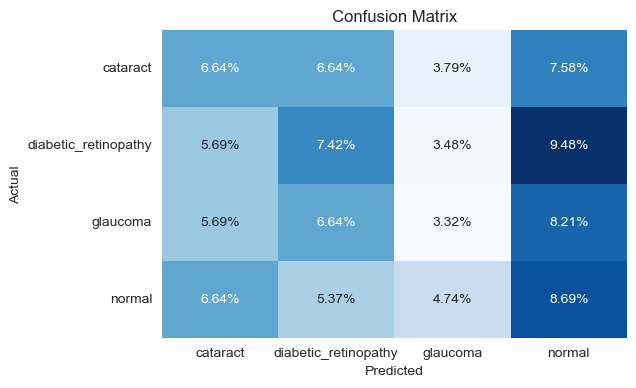

CPU times: total: 5.36 s
Wall time: 4.56 s


In [56]:
%%time
classes = list(testGen.class_indices.keys())
preds = model.predict(testGen)
yPred = np.argmax(preds, axis=1)

report = resultAnalysisFnx(testGen.classes,yPred,classes)

In [57]:
resultRecordFnx(report, 'custom2TensorFlow')
modelRecord

,ModelName,testAccuracy,testF1,testPrecision,testRecall
0,custom1TensorFlow,0.252765,0.252312,0.252480,0.252169
1,custom2TensorFlow,0.260664,0.253997,0.256597,0.258692


---

In [59]:
%%time
#Target Image Size. Original Image Size is (512,512)
imageSize = (224, 224)
color = 'rgb'
colorChannel = 3
imageShape = (imageSize[0],imageSize[1],colorChannel)
batch_size = 64

imgGen = ImageDataGenerator(rescale = 1/255,horizontal_flip=True,vertical_flip=True,rotation_range=45)

trainGen = imgGen.flow_from_dataframe(trainSamples,x_col='filepath',y_col='label',class_mode='categorical',
                                      color_mode=color,target_size=imageSize,batch_size=batch_size)
valGen = imgGen.flow_from_dataframe(validSamples,x_col='filepath',y_col='label',class_mode='categorical',
                                    color_mode=color,target_size=imageSize,batch_size=batch_size)
testGen = imgGen.flow_from_dataframe(testSamples,x_col='filepath',y_col='label',class_mode='categorical',
                                     color_mode=color,target_size=imageSize,batch_size=batch_size)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
CPU times: total: 172 ms
Wall time: 169 ms


### AlexNet Architecture
* Added Data Augmentation
* Horizontal and Vertical Flips

In [60]:
from tensorflow.keras import layers, models

In [61]:
len(trainGen)

47

In [62]:
tf.keras.backend.clear_session()

model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Flatten(),

    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Print model summary to see the architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

#### Model Training

In [ ]:
%%time
telltimefnx()
model,history = modelTrainingFnx(model,epochs=30)
telltimefnx()

#### Loss Progression

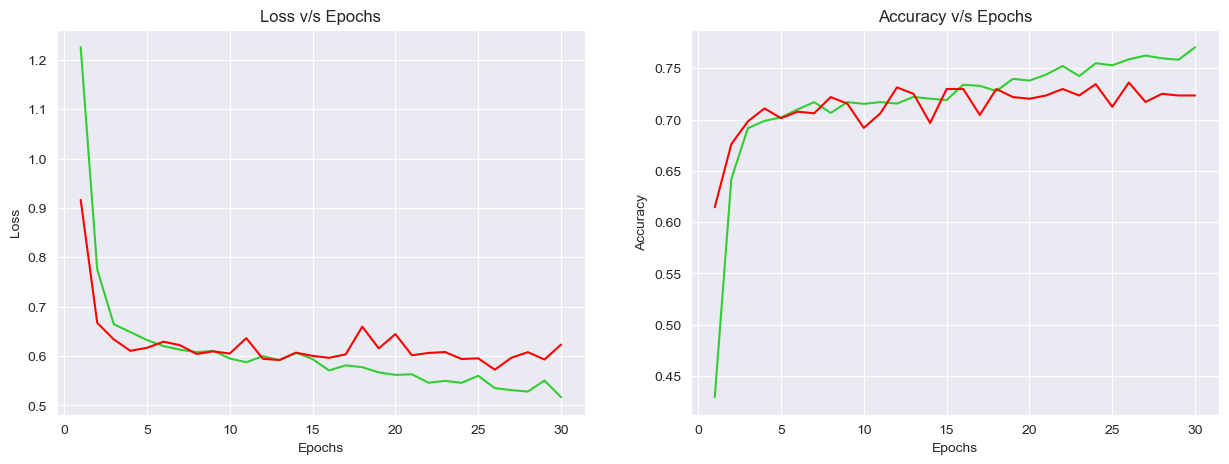

CPU times: total: 453 ms
Wall time: 389 ms


In [65]:
%%time
plotModelTraining(history)

#### Model Evaluation

In [ ]:
test_score = model.evaluate(testGen, steps= None, verbose= 1)
print("Test Loss: ", test_score[0])
print(f"Test Accuracy: {(test_score[1])*100} %", )


In [ ]:
testGen.class_indices.keys()

In [ ]:
%%time
classes = list(testGen.class_indices.keys())
preds = model.predict(testGen)
yPred = np.argmax(preds, axis=1)

print(classification_report(testGen.classes, yPred, target_names= classes))

In [ ]:
%%time
conf_matrix = confusion_matrix(testGen.classes, yPred,normalize='true')

plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(conf_matrix, annot=True,xticklabels=classes,yticklabels=classes,linewidths=0.5)
plt.xlabel("Predicted Diagnosis")
plt.ylabel("Actual Diagnosis")
plt.title("Confusion Matrix")
plt.show()

## Shifting to PyTorch

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch using device: {device}")

PyTorch using device: cuda


### AlexNet on Torch

In [38]:
dataPath = r"C:\Users\asuto\Desktop\Work\Eye Diseases\dataset"

In [39]:
#Target Image Size. Original Image Size is (512,512)
imageSize = (224, 224)
color = 'rgb'
colorChannel = 3
imageShape = (imageSize[0],imageSize[1],colorChannel)
batch_size = 6

In [40]:
transformFnx = v2.Compose([v2.ToImage(),
                           v2.Resize(imageSize),
                           v2.RandomHorizontalFlip(0.5),
                           v2.ToDtype(torch.float32, scale=True)])


dataset = datasets.ImageFolder(dataPath,transform=transformFnx)

trainData,valData,testData = torch.utils.data.random_split(dataset,[0.7,0.15,0.15])


dataLoad_train = DataLoader(trainData,batch_size=batch_size,shuffle=True)
dataLoad_val = DataLoader(valData,batch_size=batch_size,shuffle=True)
dataLoad_test = DataLoader(testData,batch_size=batch_size,shuffle=True)

#### Model Setup & Training

In [41]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 4):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            #layer 1
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),

            #layer 2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            #layer 3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #layer 4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #layer 5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            #layer 6
            nn.Dropout(p=0.5),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            #layer 7
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            #layer 8 Fin.
            nn.Linear(4096, num_classes)
        )

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

model = AlexNet(num_classes = 4)
model.to(device)

print(summary(model,input_size=(1,3,224,224)))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [43]:
%%time
telltimefnx()
num_epochs = 40

totLoss,totLossV = [],[]

totAcc,totAccV = [],[]

for epc in range(num_epochs):
    model.train()

    running_loss,correct,total = 0,0,0

    for inp,label in dataLoad_train:
        inp,label = inp.to(device),label.to(device)

        optimizer.zero_grad()

        output = model(inp)
        loss = criterion(output,label)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(output,1)
        total += label.size(0)
        correct += (pred==label).sum().item()
    totLoss.append(running_loss/len(dataLoad_train))
    totAcc.append(100 * correct/total)
    print(f"Epoch {epc+1}/{num_epochs}, Loss: {running_loss/len(dataLoad_train)}, Accuracy: {100 * correct/total}%")

    model.eval()
    val_loss,val_correct,val_total = 0,0,0

    for inpV,labelV in dataLoad_val:
        inpV,labelV = inpV.to(device),labelV.to(device)

        outputV = model(inpV)
        lossV = criterion(outputV,labelV)

        val_loss += lossV.item()
        _,pred = torch.max(outputV,1)

        val_total += labelV.size(0)
        val_correct += (pred==labelV).sum().item()
    totLossV.append(val_loss/len(dataLoad_val))
    totAccV.append(100 * val_correct / val_total)
    print(f"Validation Data: {val_loss/len(dataLoad_val):.4f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%")

telltimefnx()

Time Now: 2024.12.08 08:53 AM 
Epoch 1/40, Loss: 1.375116428466347, Accuracy: 27.913279132791327%
Validation Data: 1.3342, Validation Accuracy: 20.70%
Epoch 2/40, Loss: 1.2081978129056412, Accuracy: 40.95528455284553%
Validation Data: 1.0610, Validation Accuracy: 46.29%
Epoch 3/40, Loss: 1.0111239176940143, Accuracy: 50.67750677506775%
Validation Data: 0.7630, Validation Accuracy: 59.08%
Epoch 4/40, Loss: 0.8248318523638011, Accuracy: 59.518970189701896%
Validation Data: 0.6566, Validation Accuracy: 68.09%
Epoch 5/40, Loss: 0.7494186596884355, Accuracy: 64.46476964769647%
Validation Data: 0.6047, Validation Accuracy: 70.14%
Epoch 6/40, Loss: 0.6991783074762036, Accuracy: 65.71815718157181%
Validation Data: 0.5856, Validation Accuracy: 71.88%
Epoch 7/40, Loss: 0.6666411097441626, Accuracy: 66.46341463414635%
Validation Data: 0.7633, Validation Accuracy: 64.45%
Epoch 8/40, Loss: 0.665722821331848, Accuracy: 67.51355013550136%
Validation Data: 0.6170, Validation Accuracy: 69.51%
Epoch 9/4

In [44]:
%%time
torch.save(model, r'C:\Users\asuto\Desktop\Work\Eye Diseases\models\AlexNetModel.pth') 

CPU times: total: 891 ms
Wall time: 673 ms


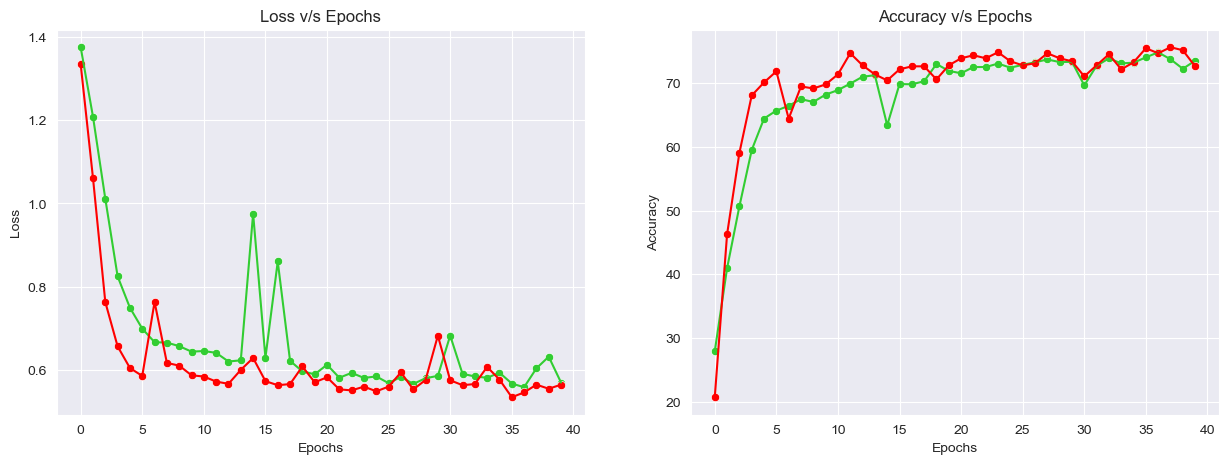

In [45]:
f, ax= plt.subplots(1, 2, sharey=False,figsize=(15,5),dpi=100)

sns.lineplot(totLoss,color='limegreen',ax=ax[0])
sns.lineplot(totLossV,color='red',ax=ax[0])
sns.scatterplot(totLoss,color='limegreen',ax=ax[0])
sns.scatterplot(totLossV,color='red',ax=ax[0])

sns.lineplot(totAcc,color='limegreen',ax=ax[1])
sns.lineplot(totAccV,color='red',ax=ax[1])
sns.scatterplot(totAcc,color='limegreen',ax=ax[1])
sns.scatterplot(totAccV,color='red',ax=ax[1])

ax[0].set_title(f'Loss v/s Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].set_title(f'Accuracy v/s Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')


plt.show()

In [46]:
%%time
model.eval()
test_correct = 0
test_total = 0

testActual,testPred = [],[]
with torch.no_grad():
    for inputs, labels in dataLoad_test:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        testActual.extend(labels.tolist())
        testPred.extend(predicted.tolist())

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

classIdx = {dataset.class_to_idx[i]:i for i in dataset.class_to_idx}
print(classIdx)
testActual = [classIdx[i] for i in testActual]
testPred = [classIdx[i] for i in testPred]

Test Accuracy: 71.52%
{0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}
CPU times: total: 1min 13s
Wall time: 12.2 s


In [47]:
print(classification_report(testActual, testPred))

                      precision    recall  f1-score   support

            cataract       0.60      0.42      0.49       162
diabetic_retinopathy       1.00      0.98      0.99       177
            glaucoma       0.52      0.36      0.43       130
              normal       0.64      1.00      0.78       163

            accuracy                           0.72       632
           macro avg       0.69      0.69      0.67       632
        weighted avg       0.71      0.72      0.69       632



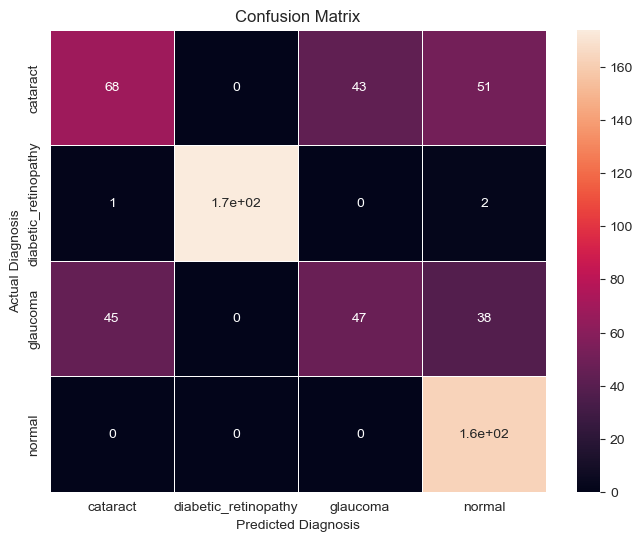

CPU times: total: 875 ms
Wall time: 321 ms


In [48]:
%%time
conf_matrix = confusion_matrix(testActual, testPred,normalize='true')
conf_matrix = confusion_matrix(testActual, testPred,normalize=None)
plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(conf_matrix, annot=True,xticklabels=dataset.classes,yticklabels=dataset.classes,linewidths=0.5)
plt.xlabel("Predicted Diagnosis")
plt.ylabel("Actual Diagnosis")
plt.title("Confusion Matrix")
plt.show()

**Achieving a test data accuracy of 70.25%**

## Transfer Learning - ResNet Series
* PreTrained Model

In [84]:
%%time
import torchvision.models as models
model = models.resnet50(pretrained=True)

# Modifiying output layer for 4 classes
model.fc = nn.Linear(2048,4,bias=True)

CPU times: total: 453 ms
Wall time: 365 ms


In [87]:
print(summary(model,input_size=(1,3,224,224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]    

In [88]:
# Freezing the neural network
for param in model.parameters():
    param.requires_grad = False

# Unfreezing the final layer
for param in model.fc.parameters():
    param.requires_grad = True

In [89]:
if torch.cuda.is_available():
    model.cuda()

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [91]:
%%time
telltimefnx()
num_epochs = 20

totLoss,totLossV = [],[]

totAcc,totAccV = [],[]

for epc in range(num_epochs):
    model.train()

    running_loss,correct,total = 0,0,0

    for inp,label in dataLoad_train:
        inp,label = inp.to(device),label.to(device)

        optimizer.zero_grad()

        output = model(inp)
        loss = criterion(output,label)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(output,1)
        total += label.size(0)
        correct += (pred==label).sum().item()
    totLoss.append(running_loss/len(dataLoad_train))
    totAcc.append(100 * correct/total)
    print(f"Epoch {epc+1}/{num_epochs}, Loss: {running_loss/len(dataLoad_train)}, Accuracy: {100 * correct/total}%")

    model.eval()
    val_loss,val_correct,val_total = 0,0,0

    for inpV,labelV in dataLoad_val:
        inpV,labelV = inpV.to(device),labelV.to(device)

        outputV = model(inpV)
        lossV = criterion(outputV,labelV)

        val_loss += lossV.item()
        _,pred = torch.max(outputV,1)

        val_total += labelV.size(0)
        val_correct += (pred==labelV).sum().item()
    totLossV.append(val_loss/len(dataLoad_val))
    totAccV.append(100 * val_correct / val_total)
    print(f"Validation Data: {val_loss/len(dataLoad_val):.4f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%")

telltimefnx()

Time Now: 2024.12.08 10:52 AM 
Epoch 1/20, Loss: 0.8766723910301197, Accuracy: 63.516260162601625%
Validation Data: 0.5960, Validation Accuracy: 75.04%
Epoch 2/20, Loss: 0.7021355515088492, Accuracy: 71.91734417344173%
Validation Data: 0.4432, Validation Accuracy: 82.15%
Epoch 3/20, Loss: 0.6762249367917336, Accuracy: 73.3739837398374%
Validation Data: 0.5619, Validation Accuracy: 77.57%
Epoch 4/20, Loss: 0.6717202752058175, Accuracy: 74.49186991869918%
Validation Data: 0.4377, Validation Accuracy: 82.94%
Epoch 5/20, Loss: 0.623620651484414, Accuracy: 76.0840108401084%
Validation Data: 0.3958, Validation Accuracy: 85.62%
Epoch 6/20, Loss: 0.6357376982677516, Accuracy: 75.94850948509485%
Validation Data: 0.4628, Validation Accuracy: 82.31%
Epoch 7/20, Loss: 0.650765516795218, Accuracy: 75.84688346883469%
Validation Data: 0.4334, Validation Accuracy: 81.83%
Epoch 8/20, Loss: 0.6077046343996152, Accuracy: 76.69376693766938%
Validation Data: 0.3914, Validation Accuracy: 85.15%
Epoch 9/20, 

In [92]:
%%time
torch.save(model, r'C:\Users\asuto\Desktop\Work\Eye Diseases\models\ResNet50Model.pth') 

CPU times: total: 500 ms
Wall time: 295 ms


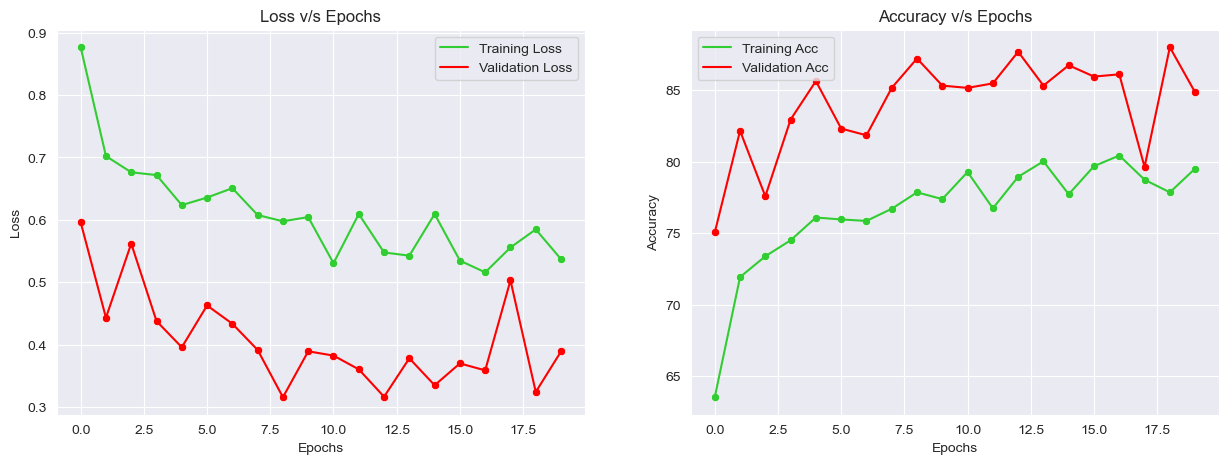

In [93]:
f, ax= plt.subplots(1, 2, sharey=False,figsize=(15,5),dpi=100)

sns.lineplot(totLoss,color='limegreen',ax=ax[0],label='Training Loss')
sns.lineplot(totLossV,color='red',ax=ax[0],label='Validation Loss')
sns.scatterplot(totLoss,color='limegreen',ax=ax[0])
sns.scatterplot(totLossV,color='red',ax=ax[0])

sns.lineplot(totAcc,color='limegreen',ax=ax[1],label='Training Acc')
sns.lineplot(totAccV,color='red',ax=ax[1],label='Validation Acc')
sns.scatterplot(totAcc,color='limegreen',ax=ax[1])
sns.scatterplot(totAccV,color='red',ax=ax[1])

ax[0].set_title(f'Loss v/s Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].set_title(f'Accuracy v/s Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')


plt.show()

In [94]:
%%time
model.eval()
test_correct = 0
test_total = 0

testActual,testPred = [],[]
with torch.no_grad():
    for inputs, labels in dataLoad_test:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        testActual.extend(labels.tolist())
        testPred.extend(predicted.tolist())

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

classIdx = {dataset.class_to_idx[i]:i for i in dataset.class_to_idx}
print(classIdx)
testActual = [classIdx[i] for i in testActual]
testPred = [classIdx[i] for i in testPred]

Test Accuracy: 87.50%
{0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}
CPU times: total: 1min 25s
Wall time: 14.3 s


In [95]:
print(classification_report(testActual, testPred))

                      precision    recall  f1-score   support

            cataract       0.76      0.99      0.86       162
diabetic_retinopathy       0.96      0.97      0.96       177
            glaucoma       0.93      0.61      0.73       130
              normal       0.91      0.88      0.89       163

            accuracy                           0.88       632
           macro avg       0.89      0.86      0.86       632
        weighted avg       0.89      0.88      0.87       632



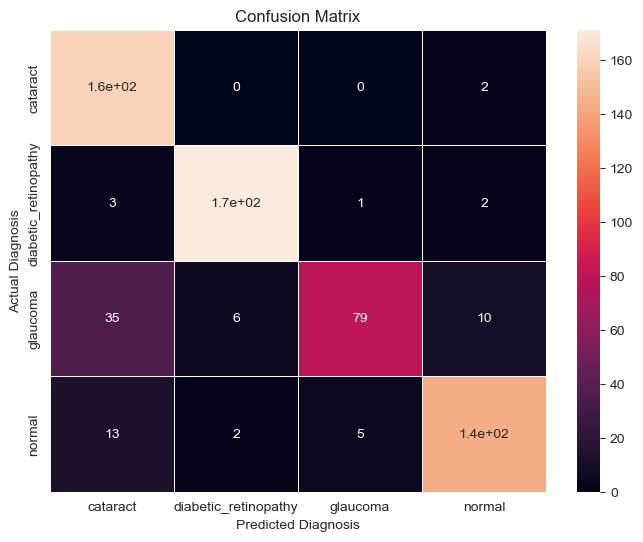

CPU times: total: 766 ms
Wall time: 416 ms


In [96]:
%%time
conf_matrix = confusion_matrix(testActual, testPred,normalize='true')
conf_matrix = confusion_matrix(testActual, testPred,normalize=None)
plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(conf_matrix, annot=True,xticklabels=dataset.classes,yticklabels=dataset.classes,linewidths=0.5)
plt.xlabel("Predicted Diagnosis")
plt.ylabel("Actual Diagnosis")
plt.title("Confusion Matrix")
plt.show()

**Achieving a test data accuracy of 88%**